In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')  

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pytz
from pytz import common_timezones, all_timezones
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
from datetime import datetime

matplotlib.style.use('fivethirtyeight')
matplotlib.style.use('seaborn-talk')

## <font color='steelblue'>Going over the lifelines package</font>

### <font color='steelblue'>Kaplan-Meier and Nelson-Aalen</font>

Let's start by importing some data. We need the durations that individuals are observed for, and whether they "died" or not.

In [3]:
from lifelines.datasets import load_waltons
df = load_waltons() # returns a Pandas DataFrame

print(df.head())

      T  E    group
0   6.0  1  miR-137
1  13.0  1  miR-137
2  13.0  1  miR-137
3  13.0  1  miR-137
4  19.0  1  miR-137


In [5]:
T = df['T']
E = df['E']

```T``` is an array of durations, ```E``` is either boolean or binary array representing whether the "death" was observed (alternatively an individual can be censored).

### Note

By default, _lifelines_ assumes all "deaths" are obsersved ( == 1)

In [7]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E) # more succiently, kmf.fit(T,E)

<lifelines.KaplanMeierFitter: fitted with 163 observations, 7 censored>

After calling the ```fit``` method, we have access to new properties like ```survival_function_``` and methods like ```plot()```. The latter is a wrapper around Pandas internal plotting library.

* ```kmf.survival_function_```
* ```kmf.median_```
* ```kmf.plot()```

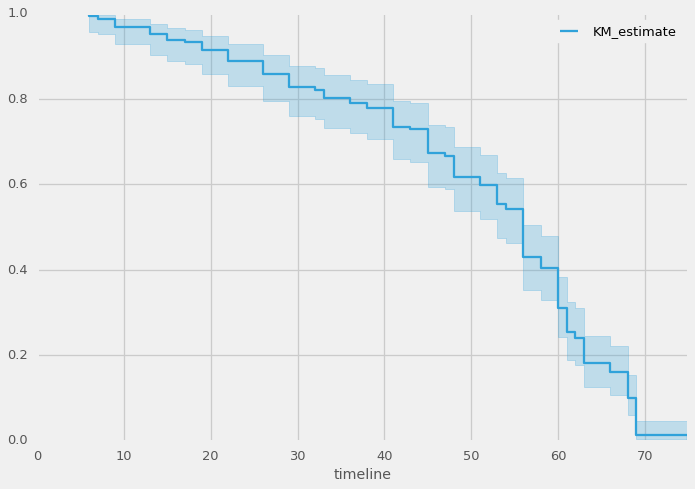

In [9]:
kmf.plot();

## Multiple groups

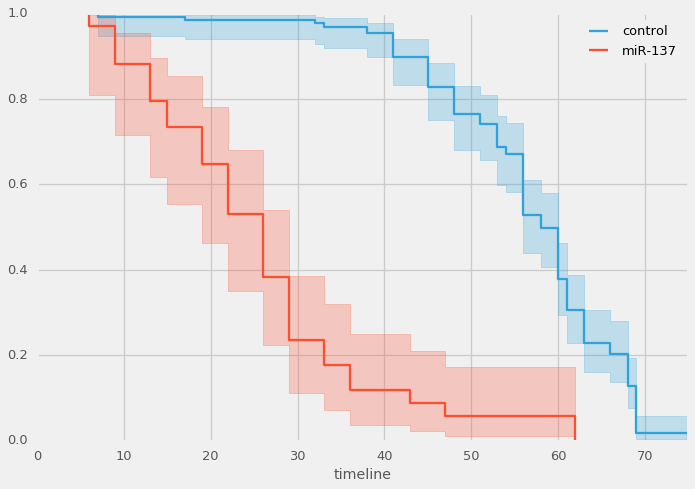

In [11]:
groups = df['group']
ix = (groups == 'miR-137')

kmf.fit(T[~ix], E[~ix], label='control')
ax = kmf.plot()

kmf2 = KaplanMeierFitter()

kmf2.fit(T[ix], E[ix], label='miR-137')
kmf2.plot(ax=ax)

Similar functionality exists for the ```NelsonAalenFitter```:

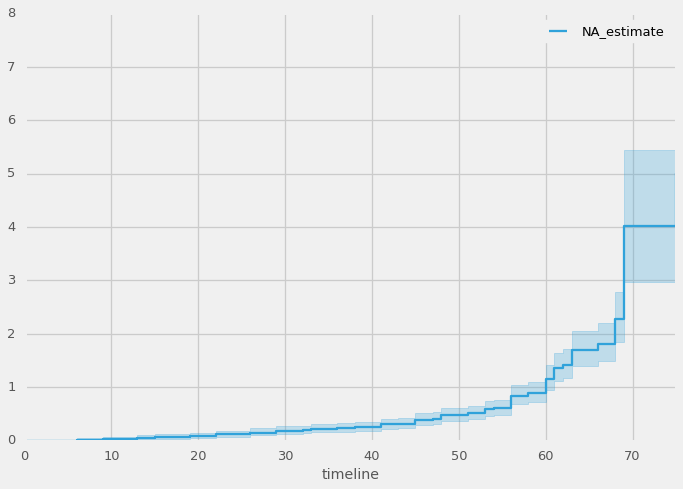

In [12]:
from lifelines import NelsonAalenFitter
naf = NelsonAalenFitter()
naf.fit(T, event_observed=E)
naf.plot()

but instead of a ```survival_function_``` being exposed, a ```cumulative_hazard_``` is

Perhaps you are interested in viewing the survival table given some durations and censorship vectors:

In [14]:
from lifelines.utils import survival_table_from_events

table = survival_table_from_events(T, E)
print(table.head())


          removed  observed  censored  entrance  at_risk
event_at                                                
0.0           0.0       0.0       0.0     163.0    163.0
6.0           1.0       1.0       0.0       0.0    163.0
7.0           2.0       1.0       1.0       0.0    162.0
9.0           3.0       3.0       0.0       0.0    160.0
13.0          3.0       3.0       0.0       0.0    157.0


## <font color='steelblue'>Survival Regression</font>

While the above ```KaplanMeierFitter``` and ```NelsonAalenFitter``` are useful, they only give us an "average" view of the population. Often we hvae specific data at the individual level, either continuous or categorical, that we would like to use. For this, we turn to **survival regression**, specifically ```AalenAdditiveFitter``` or ```CoxPHFitter```.

In [15]:
from lifelines.datasets import load_regression_dataset
regression_dataset = load_regression_dataset()

regression_dataset.head()


,var1,var2,var3,T,E
0,0.595170,1.143472,1.571079,14.785479,1
1,0.209325,0.184677,0.356980,7.336734,1
2,0.693919,0.071893,0.557960,5.271527,1
3,0.443804,1.364646,0.374221,11.684168,1
4,1.613324,0.125566,1.921325,7.637764,1


The input of the ```fit``` method's API on ```AalenAdditiveFitter``` is different than above. All the data, including duratoins, censorships and covariates must be contained in a **Pandas Dataframe** (yes, it must be a DataFrame). The duration column and event column must be specified in the call to ```fit```:

In [16]:
from lifelines import AalenAdditiveFitter, CoxPHFitter

# Using Cox Proportional Hazards model
cf = CoxPHFitter()
cf.fit(regression_dataset, 'T', event_col='E')
cf.print_summary()

# Using Aalen's Additive model
aaf = AalenAdditiveFitter(fit_intercept=False)
aaf.fit(regression_dataset, 'T', event_col='E')

n=200, number of events=189

          coef  exp(coef)  se(coef)         z         p  lower 0.95  upper 0.95    
var1 2.084e-01  1.232e+00 6.991e-02 2.981e+00 2.876e-03   7.134e-02   3.455e-01  **
var2 4.601e-02  1.047e+00 7.507e-02 6.129e-01 5.400e-01  -1.012e-01   1.932e-01    
var3 2.110e-01  1.235e+00 7.314e-02 2.885e+00 3.913e-03   6.764e-02   3.544e-01  **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.580
 [-----------------100%-----------------] 189 of 189 complete in 0.1 sec


<lifelines.AalenAdditiveFitter: fitted with 200 observations, 11 censored>

After fitting, you'll have access to properties like ```cumulative_hazards_``` and methods like ```plot```, ```predict_cumulative_hazards```, and ```predict_survival_function```. The latter two methods require an additional argument of individual covarites:

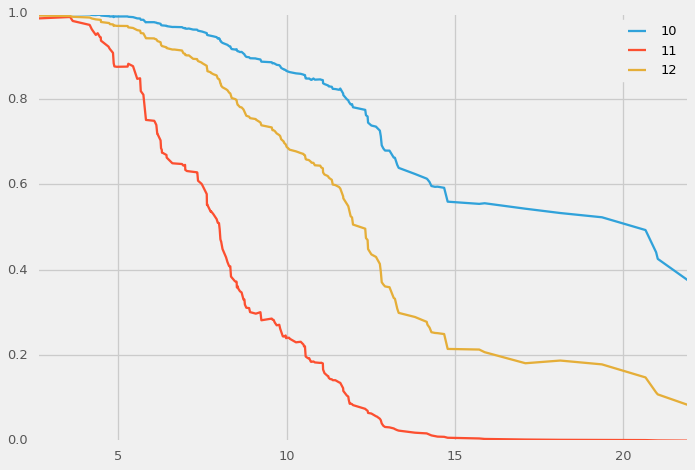

In [23]:
x = regression_dataset[list(set(regression_dataset.columns).difference(set(['E','T'])))]
aaf.predict_survival_function(x.ix[10:12]).plot(); #get the unique survival functions of the first two subjects